# `osmnx` – Arbeiten mit Straßendaten von Open Street Map

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.10'

## Lade das Straßennetz von Iserlohn

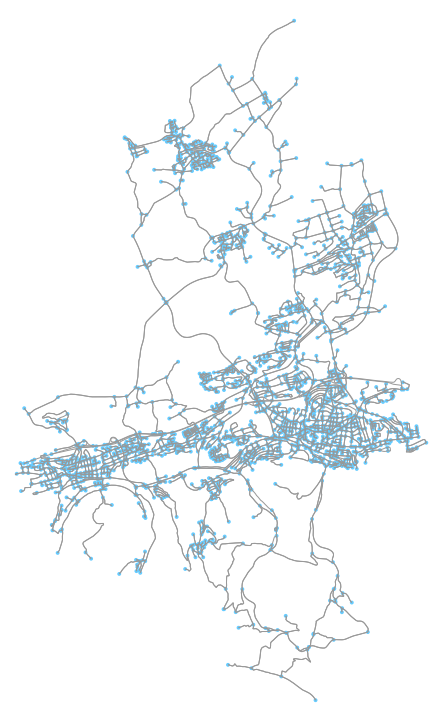

In [11]:
G = ox.graph_from_place('Iserlohn, DE', network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=13)

## Wie groß ist das Netz?

Wir wollen die Größe des Iserlohner Straßennetzes in $km^2$ 
bestimmen.

In [ ]:
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m / 1000000

## Einfache Statistiken
`osmnx` kann einige statistische Informationen zum Netz ausgeben.

In [ ]:
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

## Routing

Wir wollen vom Frauenstuhlweg 31 $(51.36817, 7.68591)$ zur Baarstraße 6 $(51.37732, 7.69582)$.

In [12]:
# get the nearest network node to each point
orig_node = ox.get_nearest_node(G, (51.36817,7.68591))
dest_node = ox.get_nearest_node(G, (51.37732,7.69582))


In [13]:
G.node[orig_node]

{'y': 51.3681499, 'x': 7.6871588, 'osmid': 599402262}

In [14]:

[ e for e in G.edges if e[0] == orig_node ]

[(599402262, 599402271, 0)]

### Dijkstra-Algorithmus

Das Paket `osmnx` enthält schon fertige Routinen für das Routing. Wir wollen hier aber "zum Spaß" einmal den Dijkstra-Algorithmus in Python implementieren.

Dazu benötigen wir eine Klasse `PriorityQueue`, die eine Menge von Punkten verwaltet, deren Abstand wir kennen, und aus der wir immer das Element mit dem kleinsten Abstand entnehmen können.

In [22]:
import heapq

class PriorityQueue:
    """Implemetierung einer PriorityQueue mit Hilfe von heapq.
    heapq verwaltet einen Heap, d.h. eine Liste von numerischen Werten mit schnellem Zugriff auf das 
    kleinste Element."""
    
    def __init__(self):
        self._queue = []
        self._index = 0

    def __len__(self):
        return self._index
    
    def push(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1
        
    def pop(self):
        """Gibt das Element mit der kleinsten Priorität zurück."""
        self._index -= 1
        return heapq.heappop(self._queue)[-1]

In [39]:
def dijkstra(G, p):
    """Der Dijkstra-Algorithmus bestimmt den Abstand aller Punkte von einem Startpunkt aus.
    Rückgabe ist ein dictionary, das zu jedem Punkt den Abstand und den Vorgänger enthält."""
    
    dist = dict()
    pred = dict()
    pq = PriorityQueue()
    
    # Initialisierung: Der Startpunkt hat Abstand 0 und keinen Vorgänger
    pq.push(p, 0)
    dist[p] = 0
    pred[p] = None
    
    # Wähle den Punkt mit dem kleinsten Abstand und aktualisiere von ihm aus die Abstände
    while len(pq) > 0:
        q = pq.pop()
        for r in nx.neighbors(G, q):
            length = G[q][r][0]['length']
            
            if (r not in dist) or (dist[q] + length < dist[r]):
                # Kürzeren Weg nach r gefunden
                #print(f"dist[{r}] = {dist[q] + length}")
                dist[r] = dist[q] + length
                pred[r] = q
                pq.push(r, dist[r])
    
    return (dist, pred)
            
        



Weg von Frauenstuhlweg zur Baarstraße: 2204.51 m
Route: [599402262, 599402271, 269660737, 306218920, 269661056, 309651617, 301134156, 301134134, 441581623, 5332098990, 599402412, 270188110, 308991218, 308996331, 350233746, 308996332, 306223351, 351118305, 306223352, 350238590, 351116797, 258592329, 351118106, 1826081634, 309651392, 258592325, 351116906]


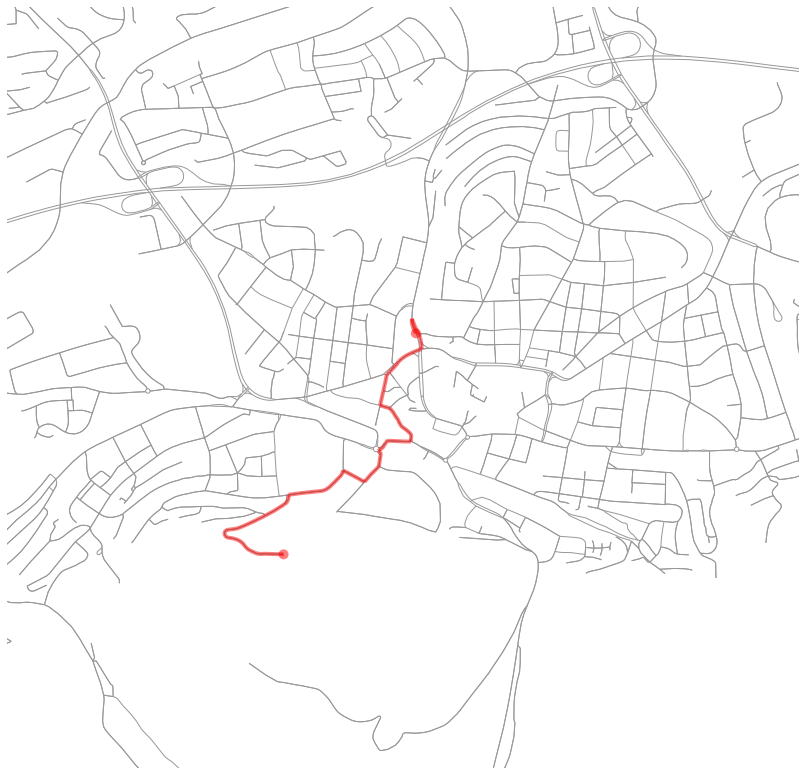

In [43]:
dist, pred = dijkstra(G, orig_node)
print(f"Weg von Frauenstuhlweg zur Baarstraße: {dist[dest_node]:.2f} m")
route = []
q = dest_node
while q is not None:
    route = [q] + route
    q = pred[q]

print(f"Route: {route}")

bbox = (51.39, 51.36, 7.72, 7.67)
fig, ax = ox.plot_graph_route(G, route, fig_height=14, bbox=bbox, node_size=0)

Zum Vergleich die Routenberechnung mit "Bordmitteln" von `osmnx`

[599402262, 599402271, 269660737, 306218920, 269661056, 309651617, 301134156, 301134134, 441581623, 5332098990, 599402412, 270188110, 308991218, 308996331, 350233746, 308996332, 306223351, 351118305, 306223352, 350238590, 351116797, 258592329, 351118106, 1826081634, 309651392, 258592325, 351116906]


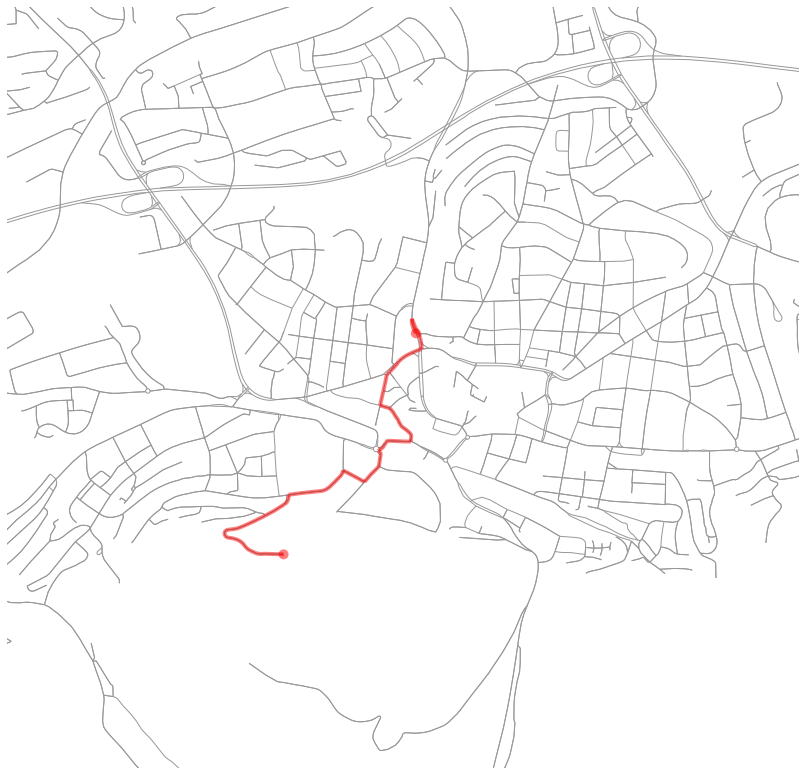

In [42]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
print(route)
bbox = (51.39, 51.36, 7.72, 7.67)
fig, ax = ox.plot_graph_route(G, route, fig_height=14, bbox=bbox, node_size=0)

In [ ]:
gdf_proj = ox.graph_to_gdfs(G_proj)
gdf_proj

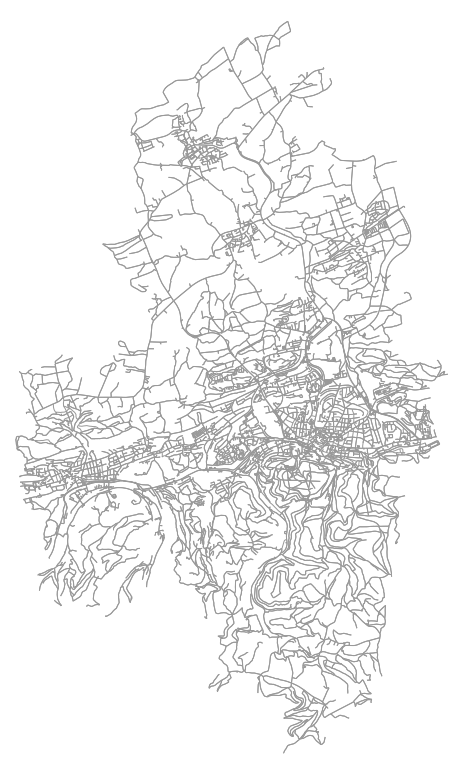

In [2]:
G = ox.graph_from_place('Iserlohn, DE',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='bike')

fig, ax = ox.plot_graph(G, fig_height=14, node_size=0)

In [3]:
from IPython.display import IFrame
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
filepath = 'graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [ ]:
G = ox.graph_from_place('Cologne, DE',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='none',infrastructure='way["railway"]')

fig, ax = ox.plot_graph(G, fig_height=10, node_size=0)